<a href="https://colab.research.google.com/github/devu294/Cell-Image-Classification-using-Pytorch/blob/main/Cell_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!ls /content/drive

MyDrive


In [3]:
import os

zip_path = '/content/drive/MyDrive/Histopathologic Cancer Detection/histopathologic_cancer_detection.zip'

if os.path.exists(zip_path):
    print("File found!")
else:
    print("File not found.")

File found!


In [4]:
import os

size_mb = os.path.getsize(zip_path) / (1024 * 1024)
print(f"File size: {size_mb:.2f} MB")

File size: 6459.45 MB


In [5]:
# adjust these paths if your dataset is elsewhere
zip_path = '/content/drive/MyDrive/Histopathologic Cancer Detection/histopathologic_cancer_detection.zip'
data_root = '/content/histopathologic_data'

In [6]:
# Unzipping dataset
import os, zipfile
if not os.path.exists(data_root):
    os.makedirs(data_root, exist_ok=True)
    if os.path.exists(zip_path):
        print('Unzipping...')
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(data_root)
        print('Unzipped to', data_root)
    else:
        print('Zip not found at', zip_path, '\nIf your data is already in Drive as a folder, set data_root accordingly.')
else:
    print('Data root exists:', data_root)

Unzipping...
Unzipped to /content/histopathologic_data


In [7]:
#Inspect data root and locate train images / labels
!ls -la "$data_root" | sed -n '1,200p'

import pandas as pd, os
csv_path = os.path.join(data_root, 'train_labels.csv')
print('\nChecking for labels CSV at', csv_path)
print('CSV exists?', os.path.exists(csv_path))

total 32140
drwxr-xr-x 4 root root     4096 Dec  7 02:15 .
drwxr-xr-x 1 root root     4096 Dec  7 02:13 ..
-rw-r--r-- 1 root root  2470703 Dec  7 02:13 sample_submission.csv
drwxr-xr-x 2 root root  4333568 Dec  7 02:13 test
drwxr-xr-x 2 root root 16625664 Dec  7 02:15 train
-rw-r--r-- 1 root root  9461084 Dec  7 02:15 train_labels.csv

Checking for labels CSV at /content/histopathologic_data/train_labels.csv
CSV exists? True


In [8]:
#Building dataframe of image paths and labels (handles CSV or folder-structured labels)
import os, pandas as pd, glob

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    # Expecting columns: id,label
    if 'id' in df.columns:
        # Assuming IDs in CSV do not have extensions, search for .png or .tif
        image_paths = []
        labels = []
        train_dir = os.path.join(data_root, 'train')
        missing_files = []
        for index, row in df.iterrows():
            img_id = str(row['id'])
            label = row['label']
            # Check for .png and .tif extensions
            png_path = os.path.join(train_dir, img_id + '.png')
            tif_path = os.path.join(train_dir, img_id + '.tif')

            if os.path.exists(png_path):
                image_paths.append(png_path)
                labels.append(label)
            elif os.path.exists(tif_path):
                image_paths.append(tif_path)
                labels.append(label)
            else:
                missing_files.append(img_id)
                # If neither exists, this image will be skipped

        df = pd.DataFrame({'path': image_paths, 'label': labels})

        # Add print statements to inspect paths
        print("Example paths found:")
        for i in range(min(5, len(df))):
            print(df.iloc[i]['path'])

        if missing_files:
            print(f"\nWarning: {len(missing_files)} files listed in CSV were not found as .png or .tif in the train directory. Examples:")
            for i in range(min(10, len(missing_files))):
                print(missing_files[i])

    else:
        print('CSV present but no "id" column; showing head:'); display(df.head())
else:
    # fallback: search for image files and infer labels from parent folder name if possible
    paths = []
    labels = []
    for root, dirs, files in os.walk(data_root):
        for f in files:
            if f.lower().endswith(('.png','.jpg','.jpeg', '.tif')): # Added .tif
                fp = os.path.join(root, f)
                parent = os.path.basename(os.path.dirname(fp))
                lab = None
                if parent in ['0','1']:
                    lab = int(parent)
                elif parent.lower() in ['cancer','tumor','malignant','1']:
                    lab = 1
                elif parent.lower() in ['normal','non-cancer','benign','0']:
                    lab = 0
                if lab is None:
                    continue
                paths.append(fp); labels.append(lab)
    df = pd.DataFrame({'path': paths, 'label': labels})

print('Total images found:', len(df))
display(df.head())

Example paths found:
/content/histopathologic_data/train/f38a6374c348f90b587e046aac6079959adf3835.tif
/content/histopathologic_data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
/content/histopathologic_data/train/755db6279dae599ebb4d39a9123cce439965282d.tif
/content/histopathologic_data/train/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
/content/histopathologic_data/train/068aba587a4950175d04c680d38943fd488d6a9d.tif
Total images found: 220025


,path,label
0,/content/histopathologic_data/train/f38a6374c3...,0
1,/content/histopathologic_data/train/c18f2d887b...,1
2,/content/histopathologic_data/train/755db6279d...,0
3,/content/histopathologic_data/train/bc3f0c64fb...,0
4,/content/histopathologic_data/train/068aba587a...,0


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('path').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['label']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('path')):
  _plot_series(series, series_name, i)
  fig.legend(title='path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('label')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('path')):
  _plot_series(series, series_name, i)
  fig.legend(title='path', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['path'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='path', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['path'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='label', y='path', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [9]:
#Dataset, transforms, dataloaders
!pip install -q torch torchvision tqdm

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import random
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class HistoDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['path']
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            label = int(row['label'])
            return img, label
        except FileNotFoundError:
            logger.error(f"FileNotFoundError: Could not find image at path: {img_path}")
            # Return None or a placeholder if a file is not found,
            # depending on how you want to handle missing files during training.
            # For now, we'll re-raise after logging to stop execution and inspect.
            raise
        except Exception as e:
            logger.error(f"Error loading image {img_path}: {e}")
            raise


# split - use the corrected df directly
val_frac = 0.1
dataset_full = HistoDataset(df, transform=train_transforms) # Use df directly
val_size = int(len(dataset_full) * val_frac)
train_size = len(dataset_full) - val_size
train_ds, val_ds = random_split(dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# ensure val uses val_transforms
val_ds.dataset.transform = val_transforms

BATCH_SIZE = 32
# Keep num_workers at 0 for debugging
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print('Train/Val sizes:', len(train_ds), len(val_ds))

Train/Val sizes: 198023 22002


In [10]:
#Model (transfer learning ResNet18)
import torch.nn as nn
import torchvision.models as models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def create_model(num_classes=2, pretrained=True, freeze_backbone=False):
    model = models.resnet18(pretrained=pretrained)
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False
    nfeat = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(nfeat, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

model = create_model(num_classes=2, pretrained=True, freeze_backbone=False).to(device)


Device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 115MB/s]


In [11]:
#Training loop: train + validate + checkpoint best model
import torch.optim as optim
from tqdm import tqdm
import copy
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

EPOCHS = 8
best_val_loss = float('inf')
save_path = '/content/best_merged_model.pth'

for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss = 0.0; train_correct = 0; total = 0
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} train')
    for imgs, labels in pbar:
        imgs = imgs.to(device); labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds==labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix(loss=loss.item(), acc=f'{train_correct/total:.4f}')
    train_loss = train_loss / total; train_acc = train_correct / total

    # validation
    model.eval()
    val_loss = 0.0; val_correct = 0; vtotal = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device); labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs,1)
            val_correct += (preds==labels).sum().item()
            vtotal += imgs.size(0)
    val_loss = val_loss / vtotal; val_acc = val_correct / vtotal

    print(f'Epoch {epoch} | train_loss {train_loss:.4f} acc {train_acc:.4f} | val_loss {val_loss:.4f} acc {val_acc:.4f}')
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch},
                   save_path)
        print('Saved best model to', save_path)

Epoch 1 train: 100%|██████████| 6189/6189 [07:54<00:00, 13.04it/s, acc=0.9400, loss=0.194]


Epoch 1 | train_loss 0.1631 acc 0.9400 | val_loss 0.1138 acc 0.9570
Saved best model to /content/best_merged_model.pth


Epoch 2 train: 100%|██████████| 6189/6189 [07:54<00:00, 13.04it/s, acc=0.9643, loss=0.107]


Epoch 2 | train_loss 0.1029 acc 0.9643 | val_loss 0.1386 acc 0.9496


Epoch 3 train: 100%|██████████| 6189/6189 [07:53<00:00, 13.08it/s, acc=0.9748, loss=0.0433]


Epoch 3 | train_loss 0.0725 acc 0.9748 | val_loss 0.0947 acc 0.9673
Saved best model to /content/best_merged_model.pth


Epoch 4 train: 100%|██████████| 6189/6189 [07:50<00:00, 13.16it/s, acc=0.9811, loss=0.000434]


Epoch 4 | train_loss 0.0541 acc 0.9811 | val_loss 0.0997 acc 0.9671


Epoch 5 train: 100%|██████████| 6189/6189 [07:50<00:00, 13.17it/s, acc=0.9864, loss=0.00203]


Epoch 5 | train_loss 0.0395 acc 0.9864 | val_loss 0.0929 acc 0.9715
Saved best model to /content/best_merged_model.pth


Epoch 6 train: 100%|██████████| 6189/6189 [07:50<00:00, 13.15it/s, acc=0.9887, loss=0.000116]


Epoch 6 | train_loss 0.0314 acc 0.9887 | val_loss 0.0897 acc 0.9728
Saved best model to /content/best_merged_model.pth


Epoch 7 train: 100%|██████████| 6189/6189 [07:47<00:00, 13.25it/s, acc=0.9907, loss=0.000207]


Epoch 7 | train_loss 0.0262 acc 0.9907 | val_loss 0.1101 acc 0.9678


Epoch 8 train: 100%|██████████| 6189/6189 [07:49<00:00, 13.19it/s, acc=0.9919, loss=0.00479]


Epoch 8 | train_loss 0.0226 acc 0.9919 | val_loss 0.1296 acc 0.9666


In [12]:
#Verify image file paths in the DataFrame
import os

def check_file_exists(path):
    return os.path.exists(path)

# Apply the check to the 'path' column
df['exists'] = df['path'].apply(check_file_exists)

# Filter out rows where the file does not exist
df_filtered = df[df['exists']].drop(columns=['exists'])

print(f"Original number of images: {len(df)}")
print(f"Number of images found: {len(df_filtered)}")

# Update the dataset with the filtered dataframe
dataset_full = HistoDataset(df_filtered, transform=train_transforms)

# Split and create dataloaders as before
val_size = int(len(dataset_full) * val_frac)
train_size = len(dataset_full) - val_size
train_ds, val_ds = random_split(dataset_full, [train_size, val_size], generator=torch.Generator().manual_seed(42))

# ensure val uses val_transforms
val_ds.dataset.transform = val_transforms

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print('Train/Val sizes after filtering:', len(train_ds), len(val_ds))

Original number of images: 220025
Number of images found: 220025
Train/Val sizes after filtering: 198023 22002


In [14]:
#Grad-CAM implementation for ResNet-type model
import torch.nn.functional as F
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        def forward_hook(module, inp, out):
            self.activations = out.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.hook_handles.append(target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(target_layer.register_backward_hook(backward_hook))

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        outputs = self.model(input_tensor)
        if class_idx is None:
            class_idx = torch.argmax(outputs, dim=1).item()
        score = outputs[0, class_idx]
        score.backward(retain_graph=True)
        grads = self.gradients[0]
        acts = self.activations[0]
        weights = torch.mean(grads, dim=(1,2))
        cam = torch.zeros(acts.shape[1:], dtype=torch.float32).to(acts.device)
        for i, w in enumerate(weights):
            cam += w * acts[i]
        cam = F.relu(cam)
        cam = cam.cpu().numpy()
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()
        cam = cv2.resize(cam, (input_tensor.shape[-1], input_tensor.shape[-2]))
        return cam

    def close(self):
        for h in self.hook_handles:
            h.remove()

Saving 3rd-2023_Lisowska_Malgorzata_e30379_f20818.jpg to 3rd-2023_Lisowska_Malgorzata_e30379_f20818.jpg

 Uploaded: 3rd-2023_Lisowska_Malgorzata_e30379_f20818.jpg
 Prediction: non-cancer  |  Confidence: 1.0000


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


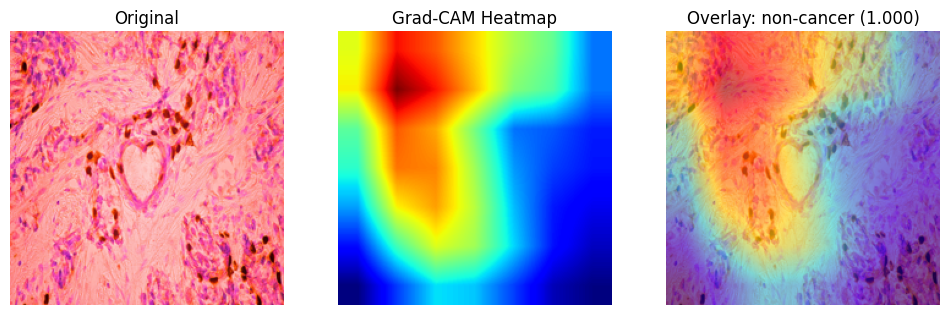


 Do you want to upload another image? (y/n): y


Saving download.jpg to download.jpg

 Uploaded: download.jpg
 Prediction: non-cancer  |  Confidence: 0.9927


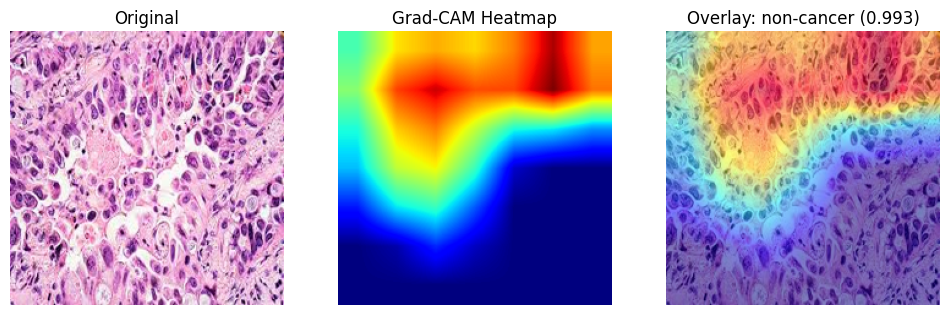


 Do you want to upload another image? (y/n): y


Saving nm-brain-tumors-up-close_feature.jpg to nm-brain-tumors-up-close_feature.jpg

 Uploaded: nm-brain-tumors-up-close_feature.jpg
 Prediction: non-cancer  |  Confidence: 0.9325


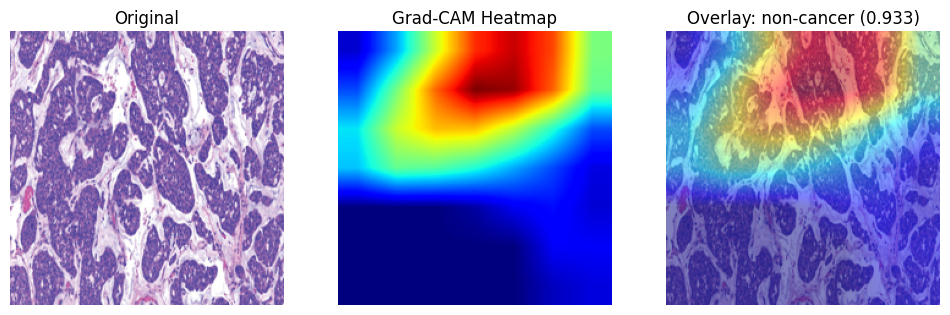


 Do you want to upload another image? (y/n): y


Saving squamous_cell_carcinoma-08846c381afe737aa26e40fb06d9e9b6-1.webp to squamous_cell_carcinoma-08846c381afe737aa26e40fb06d9e9b6-1.webp

 Uploaded: squamous_cell_carcinoma-08846c381afe737aa26e40fb06d9e9b6-1.webp
 Prediction: non-cancer  |  Confidence: 0.9995


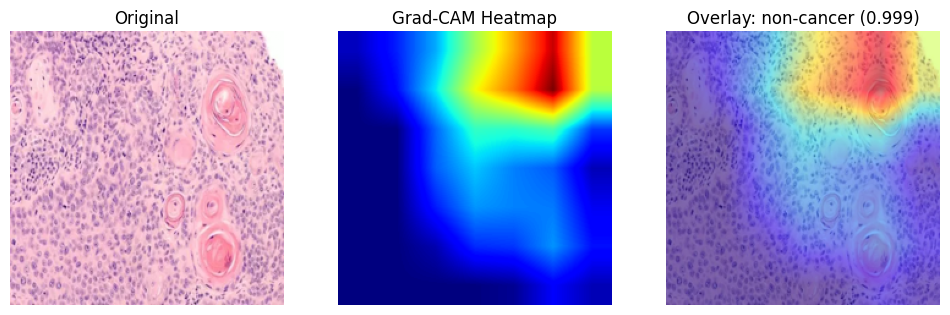


 Do you want to upload another image? (y/n): m
 Exiting inference loop.


In [15]:
# Model Run (Inference + Grad-CAM overlay)
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import cv2
import torch

def preprocess_image(pil_img, size=IMG_SIZE):
    tf = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return tf(pil_img).unsqueeze(0).to(device)

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, alpha=0.5):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    overlay = heatmap * alpha + img * (1 - alpha)
    overlay = overlay / overlay.max()
    return overlay

# load model checkpoint if exists
if os.path.exists('/content/best_merged_model.pth'):
    ck = torch.load('/content/best_merged_model.pth', map_location=device)
    model.load_state_dict(ck['model_state_dict'])
    model.to(device)
    model.eval()
else:
    print(" No saved model found at /content/best_merged_model.pth")

label_map = {0: 'non-cancer', 1: 'cancer'}

# GradCAM setup
target_layer = model.layer4[-1].conv2
gcam = GradCAM(model, target_layer=target_layer)

# interactive upload loop
while True:
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Exiting.")
        break

    local_fname = list(uploaded.keys())[0]
    print(f"\n Uploaded: {local_fname}")

    # preprocess and predict
    pil = Image.open(local_fname).convert('RGB')
    inp = preprocess_image(pil)

    with torch.no_grad():
        out = model(inp)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(probs))

    print(f" Prediction: {label_map[pred]}  |  Confidence: {probs[pred]:.4f}")

    # Grad-CAM visualization
    cam_mask = gcam.generate(inp, class_idx=pred)
    orig = np.array(pil.resize((IMG_SIZE, IMG_SIZE))).astype(np.float32) / 255.0
    overlay = show_cam_on_image(orig, cam_mask, alpha=0.5)

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(orig)
    axs[0].axis('off')
    axs[0].set_title('Original')

    axs[1].imshow(cam_mask, cmap='jet')
    axs[1].axis('off')
    axs[1].set_title('Grad-CAM Heatmap')

    axs[2].imshow(overlay)
    axs[2].axis('off')
    axs[2].set_title(f'Overlay: {label_map[pred]} ({probs[pred]:.3f})')
    plt.show()

    # ask user if they want to continue
    again = input("\n Do you want to upload another image? (y/n): ").strip().lower()
    if again != 'y':
        print(" Exiting inference loop.")
        break

gcam.close()
